# LSTM Model
The lstm model with optimal parameters

In [1]:
import pandas as pd
import csv
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
MODEL_NAME = "gpu_final_lstm"
model_file_name = MODEL_NAME + ".pt"

In [3]:
df = pd.read_csv("train_2024.csv", quoting=csv.QUOTE_NONE)
df_test = pd.read_csv("test_2024.csv", quoting=csv.QUOTE_NONE)
df_dev = pd.read_csv("dev_2024.csv", quoting=csv.QUOTE_NONE)

In [4]:
train_len = 99000
test_len = 12001
dev_len = 11000

In [5]:
df = df[:train_len]
df.shape

(99000, 3)

In [6]:
df_test = df_test[:test_len]
df_test.shape

(12001, 3)

In [7]:
df_dev = df_dev[:dev_len]
df_dev.shape

(11000, 3)

In [8]:
# Preprocessing
import re
import string

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

# https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate/34294022
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
df["text"] = df.text.map(remove_URL) # map(lambda x: remove_URL(x))
df["text"] = df.text.map(remove_punct)

df_test["text"] = df_test.text.map(remove_URL) # map(lambda x: remove_URL(x))
df_test["text"] = df_test.text.map(remove_punct)

df_dev["text"] = df_dev.text.map(remove_URL) # map(lambda x: remove_URL(x))
df_dev["text"] = df_dev.text.map(remove_punct)

In [10]:
# remove stopwords
# pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine
# has been programmed to ignore, both when indexing entries for searching and when retrieving them 
# as the result of a search query.
stop = set(stopwords.words("english"))

# https://stackoverflow.com/questions/5486337/how-to-remove-stop-words-using-nltk-or-python
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /u/27/shahine1/unix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df["text"] = df.text.map(remove_stopwords)
df_test["text"] = df_test.text.map(remove_stopwords)
df_dev["text"] = df_dev.text.map(remove_stopwords)

In [12]:
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(pd.concat([df, df_test, df_dev]).text)

In [13]:
num_unique_words = len(counter)

In [14]:
train_sentences = df.text.to_numpy()
train_labels = df.label.to_numpy()

test_sentences = df_test.text.to_numpy()

dev_sentences = df_dev.text.to_numpy()
dev_labels = df_dev.label.to_numpy()

In [15]:
# Tokenize the text data
def tokenize_text(text_data):
    # Split the text into words
    tokens = [text.split() for text in text_data]
    return tokens

# Count the occurrences of each word
def count_words(tokenized_text):
    word_counts = Counter()
    for tokens in tokenized_text:
        word_counts.update(tokens)
    return word_counts

# Map words to indices
def map_words_to_indices(tokenized_text, max_vocab_size):
    word_counts = count_words(tokenized_text)
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
    
    word_to_index = {word: index + 1 for index, word in enumerate(sorted_words[:max_vocab_size])}
    return word_to_index

# Tokenize text data
train_test_dev_tokenized = tokenize_text(np.concatenate([train_sentences, test_sentences, dev_sentences]))
# Map words to indices
word_to_index = map_words_to_indices(train_test_dev_tokenized, num_unique_words)

# Example of usage
#print(word_to_index)

In [16]:
max = 0
for sentence in train_test_dev_tokenized:
    length = len(sentence)
    if length > max:
        max = length
print("Max length: ", max)

Max length:  305


In [17]:
def lists_to_sentences(list_of_lists):
    sentences = []
    for sublist in list_of_lists:
        sentence = ' '.join(sublist)
        sentences.append(sentence)
    return sentences

train_test_dev_seq = lists_to_sentences(train_test_dev_tokenized)
#print(train_test_seq[0:3])

In [18]:
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence

# Tokenize the strings and map them to integers
word_to_index = defaultdict(lambda: len(word_to_index))  # defaultdict automatically assigns unique indices
train_test_dev_seq_int = []

for seq in train_test_dev_seq:
    tokens = seq.split()
    seq_int = [word_to_index[token] for token in tokens]
    train_test_dev_seq_int.append(seq_int)

max_length = max

# Pad sequences
train_test_dev_padded_tensor = pad_sequence([torch.tensor(seq[:max_length]) for seq in train_test_dev_seq_int], batch_first=True, padding_value=0)

In [19]:
print(train_sentences[10])
print(train_test_dev_seq_int[10])
print(train_test_dev_padded_tensor[:30])

leftists racism look greatest leftists history like hitler stalin lenen leftists usually biggest mass murders history yea left antiracist
[162, 163, 164, 165, 162, 166, 73, 167, 168, 169, 162, 170, 171, 172, 173, 166, 174, 90, 175]
tensor([[  0,   1,   2,  ...,   0,   0,   0],
        [ 10,  11,  12,  ...,   0,   0,   0],
        [ 75,  76,  77,  ...,   0,   0,   0],
        ...,
        [158, 447, 448,  ...,   0,   0,   0],
        [462, 463, 464,  ...,   0,   0,   0],
        [476, 477,  42,  ...,   0,   0,   0]])


In [20]:
# Check reversing the indices
# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_to_index.items()])

In [21]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [22]:
decoded_text = decode(train_test_dev_seq_int[10])
print(train_test_dev_seq_int[10])
print(decoded_text)

[162, 163, 164, 165, 162, 166, 73, 167, 168, 169, 162, 170, 171, 172, 173, 166, 174, 90, 175]
leftists racism look greatest leftists history like hitler stalin lenen leftists usually biggest mass murders history yea left antiracist


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.bias = bias
        self.weights = nn.Parameter(torch.Tensor(feature_dim, 1))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        # x shape: (batch, time, features)
        eij = torch.matmul(x, self.weights).squeeze(2)
        if self.bias is not None:
            eij += self.bias
        eij = torch.tanh(eij)
        a = torch.exp(eij)

        a = a / torch.sum(a, dim=1, keepdim=True)  # softmax over time dimension

        weighted_input = x * a.unsqueeze(2)
        return torch.sum(weighted_input, dim=1)


In [24]:
import torch.nn as nn
import numpy as np

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = torch.mean(output, axis=1)
        output = self.fc2(output)
        output = self.sigmoid(output)
        return output

In [25]:
# # Define the LSTM model
# import torch.nn as nn
# import numpy as np

# class LSTMModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim):
#         super(LSTMModel, self).__init__()
        
#         # self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         # self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         # self.fc2 = nn.Linear(hidden_dim, 1)
#         # self.sigmoid = nn.Sigmoid()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.layers = nn.Sequential(

#             nn.Linear(hidden_dim, 28 * 28),
#             # nn.Flatten(),                   # Flatten the input image tensor
#             nn.Linear(28 * 28, 64),         # Fully connected layer from 28*28 to 64 neurons
#             nn.BatchNorm1d(64),             # Batch normalization for stability and faster convergence
#             nn.ReLU(),                      # ReLU activation function
#             nn.Linear(64, 32),              # Fully connected layer from 64 to 32 neurons
#             nn.BatchNorm1d(32),             # Batch normalization for stability and faster convergence
#             nn.ReLU(),                      # ReLU activation function
#             nn.Linear(32, 1),               # Fully connected layer from 32 to 10 neurons (for MNIST classes)
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         embedded = self.embedding(x)
#         output, _ = self.lstm(embedded)
#         output = torch.mean(output, axis=1)
#         output = self.layers(output)
#         return output

In [26]:
# Create the model
vocab_size = num_unique_words  # Assuming num_unique_words is defined
embedding_dim = 1000
hidden_dim = 32
torch.cuda.empty_cache()
mps_device = torch.device("cuda")
model = LSTMModel(vocab_size, embedding_dim, hidden_dim)
model.to(mps_device)

# Define loss, optimizer, and metrics
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# Convert numpy arrays to torch tensors
train_padded_tensor = torch.tensor(train_test_dev_padded_tensor[:train_len], dtype=torch.long, device=mps_device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float, device=mps_device)

test_padded_tensor = torch.tensor(train_test_dev_padded_tensor[train_len:train_len+test_len], dtype=torch.long, device=mps_device)

dev_padded_tensor = torch.tensor(train_test_dev_padded_tensor[train_len+test_len:train_len+test_len+dev_len], dtype=torch.long, device=mps_device)
dev_labels_tensor = torch.tensor(dev_labels, dtype=torch.float, device=mps_device)

/tmp/ipykernel_679684/91927383.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_padded_tensor = torch.tensor(train_test_dev_padded_tensor[:train_len], dtype=torch.long, device=mps_device)
/tmp/ipykernel_679684/91927383.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_padded_tensor = torch.tensor(train_test_dev_padded_tensor[train_len:train_len+test_len], dtype=torch.long, device=mps_device)
/tmp/ipykernel_679684/91927383.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dev_padded_tensor = torch.tensor(train_test_dev

Epoch [1/100], Train Loss: 0.4881, Validation Loss: 0.2921, F1 Score: 0.8455
Epoch [2/100], Train Loss: 0.2685, Validation Loss: 0.2475, F1 Score: 0.8718
Epoch [3/100], Train Loss: 0.2610, Validation Loss: 0.2399, F1 Score: 0.8762
Epoch [4/100], Train Loss: 0.2493, Validation Loss: 0.2400, F1 Score: 0.8785
Epoch [5/100], Train Loss: 0.2330, Validation Loss: 0.2326, F1 Score: 0.8836
Epoch [6/100], Train Loss: 0.2230, Validation Loss: 0.2404, F1 Score: 0.8795
Epoch [7/100], Train Loss: 0.2170, Validation Loss: 0.2055, F1 Score: 0.8964
Epoch [8/100], Train Loss: 0.2124, Validation Loss: 0.2223, F1 Score: 0.8866
Epoch [9/100], Train Loss: 0.2097, Validation Loss: 0.2197, F1 Score: 0.8914
Epoch [10/100], Train Loss: 0.2057, Validation Loss: 0.2258, F1 Score: 0.8904
Epoch [11/100], Train Loss: 0.2022, Validation Loss: 0.2102, F1 Score: 0.8933
Epoch [12/100], Train Loss: 0.2011, Validation Loss: 0.2056, F1 Score: 0.8957
Epoch [13/100], Train Loss: 0.1976, Validation Loss: 0.2047, F1 Score: 0.

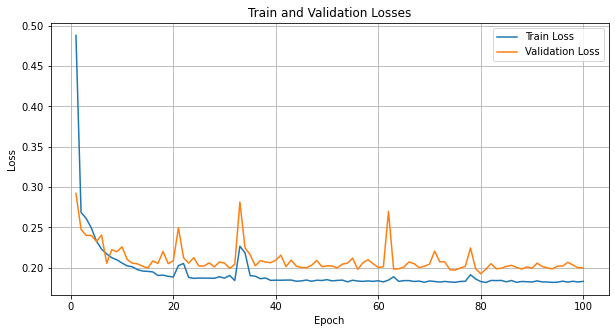

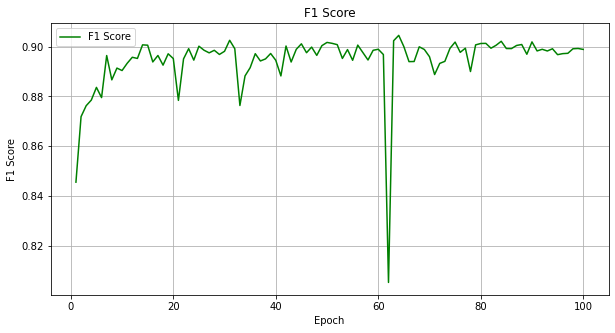

In [27]:
# Assuming train_test_padded_tensor, train_labels, test_labels, and other necessary variables are defined

# Define the batch size
batch_size = 501

# Create DataLoader for training and testing data
train_dataset = torch.utils.data.TensorDataset(train_padded_tensor, train_labels_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_padded_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# dev_dataset = torch.utils.data.TensorDataset(torch.tensor(q_matrix_sen).float(), dev_labels_tensor) 
dev_dataset = torch.utils.data.TensorDataset(dev_padded_tensor, dev_labels_tensor)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
dev_losses = []
f1_scores = []


# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(mps_device)  # Move inputs to device
        labels = labels.to(mps_device)  # Move labels to device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    dev_loss = 0.0
    dev_predictions = []
    dev_targets = []
    for inputs, labels in dev_loader:
        with torch.no_grad():
            inputs = inputs.to(mps_device)  # Move inputs to device
            labels = labels.to(mps_device)  # Move labels to device
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            dev_loss += loss.item() * inputs.size(0)
            predictions = outputs.squeeze().cpu().numpy()
            dev_predictions.extend(predictions)
            dev_targets.extend(labels.cpu().numpy())
    dev_loss /= len(dev_loader.dataset)
    dev_losses.append(dev_loss)

    dev_predictions = [1 if p > 0.5 else 0 for p in dev_predictions]
    f1 = f1_score(dev_predictions, dev_targets)
    f1_scores.append(f1)
    # if f1 >= 0.905:
    #     break
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {dev_loss:.4f}, F1 Score: {f1:.4f}')

# Plotting train and test losses
plt.figure(figsize=(10, 5),facecolor=(1, 1, 1))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), dev_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid(True)
plt.savefig('{}_train_test_loss.png'.format(MODEL_NAME)) 
plt.show()

# Plotting F1 score
plt.figure(figsize=(10, 5),facecolor=(1, 1, 1))
plt.plot(range(1, num_epochs+1), f1_scores, label='F1 Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('{}_f1_loss.png'.format(MODEL_NAME)) 
plt.show()

In [28]:
f1

0.8988593155893536

In [29]:
torch.save(model.state_dict(), "{}.pt".format(MODEL_NAME))

In [30]:
model = LSTMModel(vocab_size, embedding_dim, hidden_dim)
model.load_state_dict(torch.load("{}.pt".format(MODEL_NAME)))
model.to(mps_device)
model.eval()

LSTMModel(
  (embedding): Embedding(103346, 1000)
  (lstm): LSTM(1000, 32, batch_first=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [31]:
test_predictions = []
for inputs in test_loader:
    with torch.no_grad():
        # print(test_predictions)
        inputs = inputs[0].to(mps_device)  # Move inputs to device
        outputs = model(inputs)
        predictions = outputs.squeeze().cpu().numpy()
        print(predictions.shape)
        
        test_predictions.extend(predictions)

test_predictions = [1 if p > 0.5 else 0 for p in test_predictions]
print(len(test_predictions))

(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(501,)
(478,)
12001


In [32]:
test_predictions

[1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,


In [33]:
with open("{}.csv".format(MODEL_NAME), "w") as f:
    f.write("id,label\n")
    for i,l in enumerate(test_predictions):
        f.write(str(i)+","+str(l) +"\n")
    f.close()

# -------------------------------------------------------------------------------------------